# 7. Visual Search - Calling Azure Cognitive Search

# Visual Search with Azure Cognitive Search, Sentence Transformers, Azure Computer Vision and bar code/QR code detection

## 1. Description
The goal of this is **Azure AI asset is to enable search over Text and Images using Azure Cognitive Search**. The technique was inspired by a research article which show how to **convert vectors (embeddings) to text which allows the Cognitive Search service to leverage the inverted index to quickly find the most relevant items**. For this reason, any model that will convert an object to a vector can be leveraged if the number of dimensions in the resulting vector is less than 3,000. It also allows users to leverage existing pretrained or fine-tuned models.<br><br>

This technique has shown to be incredibly effective and easy to implement. We are using **Sentence Transformers, which is an OpenAI clip model wrapper**. We need to embed all our existing catalog of images. Then the objects embedding are converted into a set of fake terms and all the results are stored into an Azure Cognitive Search index for handling all the search requests.
For example, if an embedding looked like [-0,21, .123, ..., .876], this might be converted to a set of fake terms such as: “A1 B3 … FED0”. This is what is sent as the search query to Azure Cognitive Search.<br><br>

We can **enrich the Azure Cognitive Search index by using extracted text from the images using Azure Read API**. We can also detect and extract any information from **bar code and/or QR code** that might be available in the products catalog images. And we can use also **Azure Computer Vision as well to detect the dominant colors of the image, the tags that can describe the image and the caption of each image**. All these information will be ingested into the Azure Cognitive Search index.<br><br>

The goal of this asset is to be able to use the inverted index within Azure Cognitive Search to be able to quickly find vectors stored in the search index that are like a vector provided as part of a search query and/or using any AI extracted information (text, dominant colors, …). Unlike techniques like cosine similarity which are slow to process large numbers of items, this leverages an inverted index which enables much more data to be indexed and searched.<br>

## 2. Process

- We have here a collection of catalog images (466 images).
- For each of these images, we will embed them using Sentence Transformers.  Sentence Transformer can be used to map images and texts to the same vector space. As model, we use the OpenAI CLIP Model which was trained on a large set of images and image alt texts.
- We can retrieve any text from these images using Azure Read API (if any text is available)
- We can retrieve any text information from any bar code or QR code (if any)
- All these information will be ingested into an Azure Cognitive Search index
- Then if you have a field image, you can embed it and extract any text/barcode information and call the Azure Cognitive Search index to retrieve any similar images using vecText similarity and/or using any query text from the extracted text


<img src="https://github.com/retkowsky/images/blob/master/process.png?raw=true">

Field images are available in the field images directory (number of images=53)


## 3. Azure products documentation
- https://azure.microsoft.com/en-us/products/search/ 
- https://azure.microsoft.com/en-us/products/cognitive-services/computer-vision/#overview 
- https://learn.microsoft.com/en-us/azure/cognitive-services/Computer-vision/how-to/call-read-api 
- https://zbar.sourceforge.net/ 
- https://github.com/liamca/vector-search

## 4. Research article
https://www.researchgate.net/publication/305910626_Large_Scale_Indexing_and_Searching_Deep_Convolutional_Neural_Network_Features
    
## 5. Directories
- **images**: We have two directories (catalog images, field images)
- **model**: Directory to save the clusters of the model
- **results**: Directory to save some results
- **test**: Directory that contains some testing images

## 6. Python notebooks

### 0. Settings.ipynb
Notebook that contains the link to the images and the importation process of the python required libraries

### 1. Catalog images exploration.ipynb
This notebook will display some catalog and field images

### 2.OpenAI Clip and VecText Clusters.ipynb
This notebook will explain what sentence transformers is and will generate the clusters
This notebook analyzes a set of existing images to determine a set of "cluster centers" that will be used to determine which "fake words" are generated for a vector
This notebook will take a test set of files (testSamplesToTest) and determine the optimal way to cluster vectors into fake words that will be indexed into Azure Cognitive Search

### 3. VecText generation.ipynb
This notebook will generate the vectext embedding for all the catalog images

### 4. BarCode Information extraction.ipynb
This notebook will detect any barcode or QR code from the catalog images and will extract the information

### 5. Azure CV for OCR, tags, colors and captions.ipynb
This notebook will use Azure Computer Vision or OCR, colors, tags and caption extraction for each of the catalog images.

### 6. Azure Cognitive Search Index Generation.ipynb
This notebook will show how to ingest all the information into an Azure Cognitive Search index.

### 7. Calling Azure Cognitive Search.ipynb
We can now test the index using some images similarity visual search or free text queries using azure Cognitive Search.

## 7. Python files

- **azureCognitiveSearch.py**
This python file contains many functions to manage and use Azure Cognitive Search

- **myfunctions.py**
This python file contains many generic functions used in all the notebooks

- **vec2Text.py**
This python file contains some functions for the sentence transformers model


18-oct-2022 Serge Retkowsky | serge.retkowsky@microsoft.com | https://www.linkedin.com/in/serger/

In [1]:
import configparser
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import requests
import sys
import time

from azure.core.credentials import AzureKeyCredential
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.search.documents import SearchClient
from msrest.authentication import CognitiveServicesCredentials

import azureCognitiveSearch as acs
import myfunctions as my
import vec2Text

%matplotlib inline

In [2]:
my.get_system_info()

System Informations:

{
  "Architecture": "x86_64",
  "Hostname": "standardd13",
  "IP-address": "127.0.0.1",
  "MAC-address": "60:45:bd:90:9b:99",
  "Platform": "Linux",
  "Platform-release": "5.4.0-1077-azure",
  "Platform-version": "#80~18.04.1-Ubuntu SMP Wed Apr 13 02:07:09 UTC 2022",
  "Processor": "x86_64",
  "Python version": "3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]",
  "RAM": "55 Gb"
}


In [3]:
my.check_python()

You are using Python: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
This notebook was made using Python 3.8.5 so this is OK


Storage:

Total: 126.8 GB
- Used: 62.1 GB | 48.95 %
- Free: 64.7 GB | 51.03 %


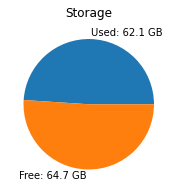

(126774263808, 62061895680, 64695590912)

In [5]:
my.get_storage_infos()

In [4]:
print("Today is:", my.get_today())

Today is: 18-10-2022 14:23:12


## 1. Loading cluster centers file

In [6]:
PKL_FOLDER = "model"
my.list_dir(PKL_FOLDER)

Files in directory: model 

1 	 2022-10-18 13:58:28.277389 29.1 kB 	 cluster_centers_images.pkl


In [7]:
cluster_center_file = 'cluster_centers_images.pkl'

In [8]:
print("Loading pkl file", cluster_center_file)

os.chdir(PKL_FOLDER)

try:
    with open(cluster_center_file, 'rb') as pickle_in:
        clusterCenters = pickle.load(pickle_in)
        print("Done.")
except:
    print("[Error]")

os.chdir("..")

Loading pkl file cluster_centers_images.pkl
Done.


In [9]:
model = vec2Text.openai_clip_model()

Loading OpenAI Clip model: clip-ViT-B-32
Done


## 2. Azure Cognitive Search Index status

In [10]:
print("Azure Cognitive Search index is:", acs.index_name)

Azure Cognitive Search index is: demo-retail


In [11]:
acs.index_status(acs.index_name)

Azure Cognitive Search Index: demo-retail 

{
    "@odata.context": "https://azurecognitivesearchsr.search.windows.net/$metadata#indexes/$entity",
    "@odata.etag": "\"0x8DAB113F266512B\"",
    "name": "demo-retail",
    "defaultScoringProfile": null,
    "fields": [
        {
            "name": "Id",
            "type": "Edm.String",
            "searchable": false,
            "filterable": false,
            "retrievable": true,
            "sortable": false,
            "facetable": false,
            "key": true,
            "indexAnalyzer": null,
            "searchAnalyzer": null,
            "analyzer": null,
            "synonymMaps": []
        },
        {
            "name": "Content",
            "type": "Edm.String",
            "searchable": true,
            "filterable": true,
            "retrievable": true,
            "sortable": true,
            "facetable": false,
            "key": false,
            "indexAnalyzer": null,
            "searchAnalyzer": null,
 

## 3. Field images

In [12]:
FIELD_IMAGES = './images/field_images/'

In [13]:
my.number_files(FIELD_IMAGES)

./images/field_images/ = 53

The directory ./images/field_images/ contains 53 files


## 4. Visual Search tests

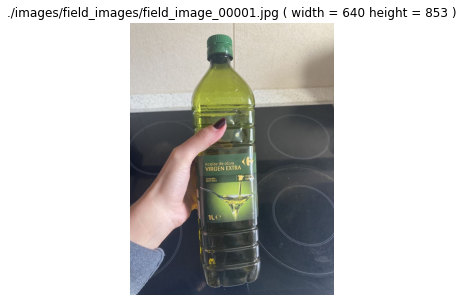

In [14]:
reference_image = FIELD_IMAGES + "field_image_00001.jpg"
my.image_view(reference_image, w=10, h=5, axis=False)

In [15]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=3)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 3 similar images of reference image: ./images/field_images/field_image_00001.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00059.jpg Similarity score = 210.91092 
 2 Similar image: ./images/catalog_images/catalog_image_00061.jpg Similarity score = 205.34302 
 3 Similar image: ./images/catalog_images/catalog_image_00455.jpg Similarity score = 199.2037 

Done in 1.61248 secs


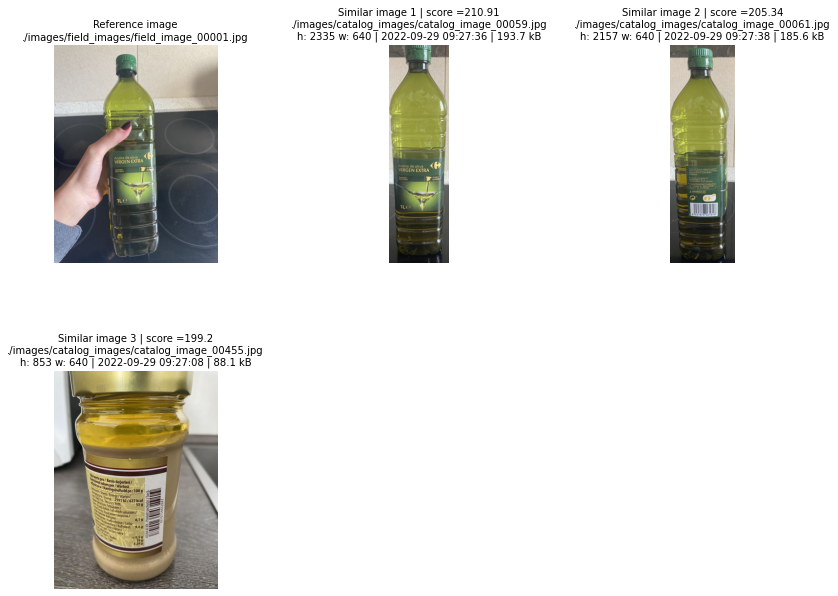

In [16]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

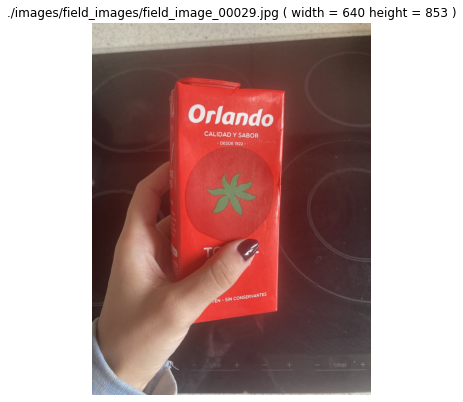

In [17]:
reference_image = FIELD_IMAGES + "field_image_00029.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [18]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=5)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 5 similar images of reference image: ./images/field_images/field_image_00029.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00372.jpg Similarity score = 247.82951 
 2 Similar image: ./images/catalog_images/catalog_image_00055.jpg Similarity score = 228.88914 
 3 Similar image: ./images/catalog_images/catalog_image_00058.jpg Similarity score = 213.9034 
 4 Similar image: ./images/catalog_images/catalog_image_00056.jpg Similarity score = 191.38213 
 5 Similar image: ./images/catalog_images/catalog_image_00376.jpg Similarity score = 188.84813 

Done in 1.2031 secs


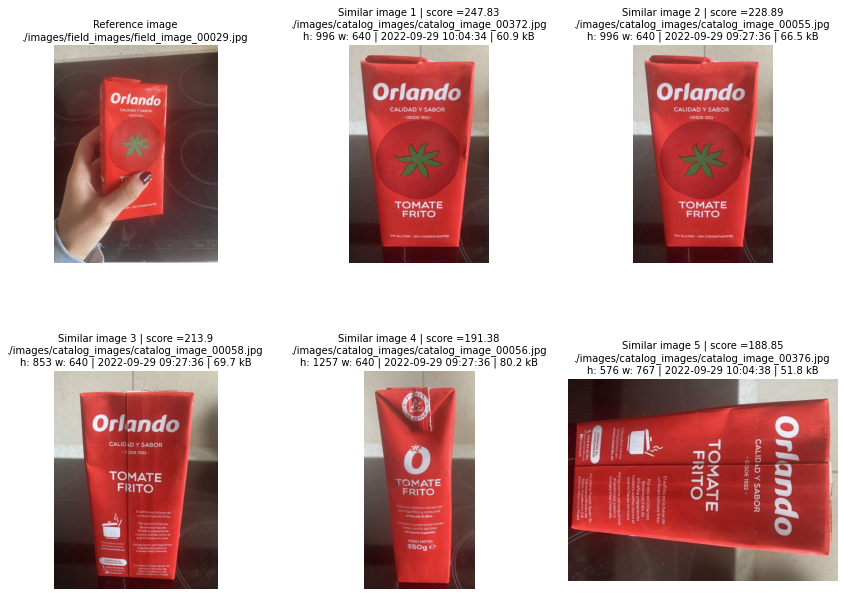

In [19]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

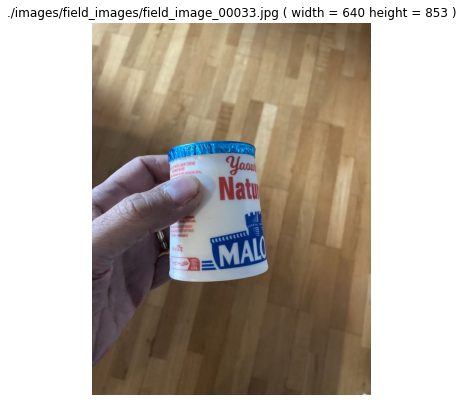

In [20]:
reference_image = FIELD_IMAGES + "field_image_00033.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [21]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=5)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 5 similar images of reference image: ./images/field_images/field_image_00033.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00096.jpg Similarity score = 221.79428 
 2 Similar image: ./images/catalog_images/catalog_image_00095.jpg Similarity score = 220.81505 
 3 Similar image: ./images/catalog_images/catalog_image_00013.jpg Similarity score = 211.81728 
 4 Similar image: ./images/catalog_images/catalog_image_00098.jpg Similarity score = 209.06192 
 5 Similar image: ./images/catalog_images/catalog_image_00002.jpg Similarity score = 207.65028 

Done in 1.23654 secs


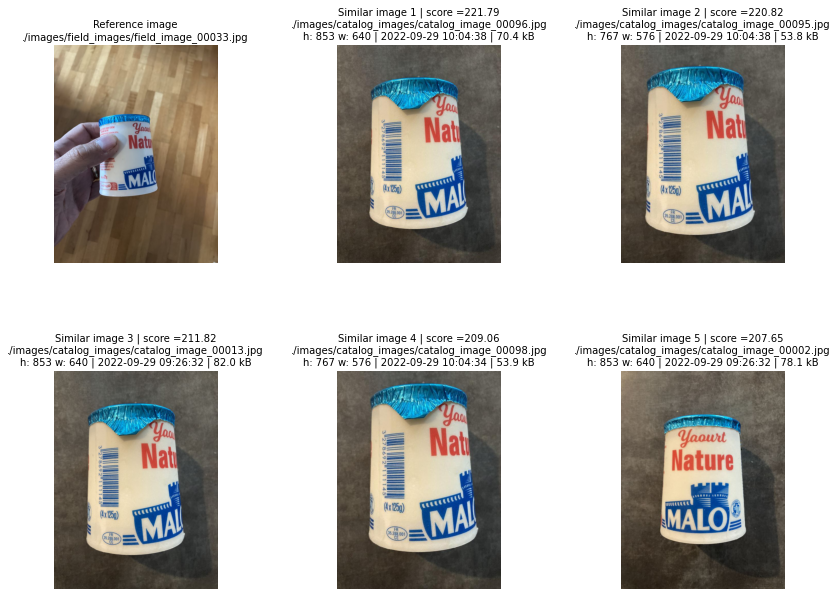

In [22]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

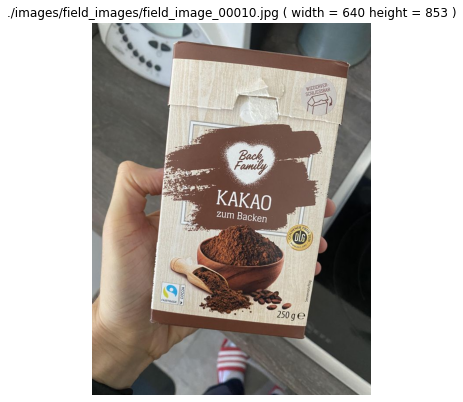

In [23]:
reference_image = FIELD_IMAGES + "field_image_00010.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [24]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=5)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 5 similar images of reference image: ./images/field_images/field_image_00010.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00230.jpg Similarity score = 291.76907 
 2 Similar image: ./images/catalog_images/catalog_image_00232.jpg Similarity score = 281.6423 
 3 Similar image: ./images/catalog_images/catalog_image_00231.jpg Similarity score = 273.59644 
 4 Similar image: ./images/catalog_images/catalog_image_00451.jpg Similarity score = 264.68744 
 5 Similar image: ./images/catalog_images/catalog_image_00442.jpg Similarity score = 182.7643 

Done in 1.23415 secs


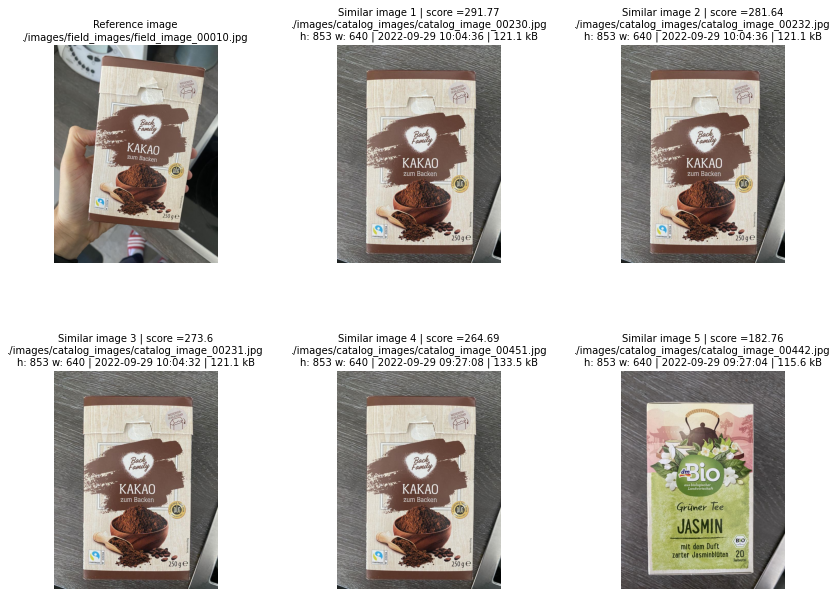

In [25]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

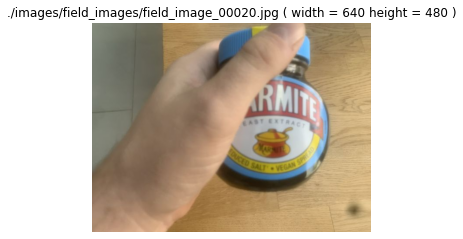

In [26]:
reference_image = FIELD_IMAGES + "field_image_00020.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [27]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=4)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 4 similar images of reference image: ./images/field_images/field_image_00020.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00028.jpg Similarity score = 212.99686 
 2 Similar image: ./images/catalog_images/catalog_image_00318.jpg Similarity score = 195.10513 
 3 Similar image: ./images/catalog_images/catalog_image_00317.jpg Similarity score = 180.42265 
 4 Similar image: ./images/catalog_images/catalog_image_00029.jpg Similarity score = 179.91824 

Done in 1.16572 secs


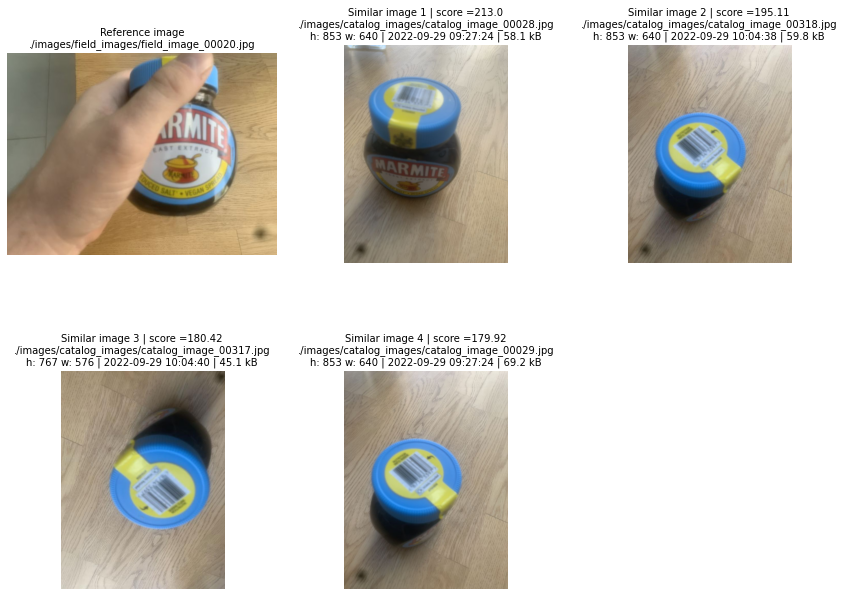

In [28]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

## 5. Visual Search using Open AI Clip text

Finding 1 images with Open AI text query: BUTTER 

{'Content': './images/catalog_images/catalog_image_00039.jpg', '@search.score': 190.9799, '@search.highlights': None}

1 Image file: ./images/catalog_images/catalog_image_00039.jpg
Similarity score = 190.9799


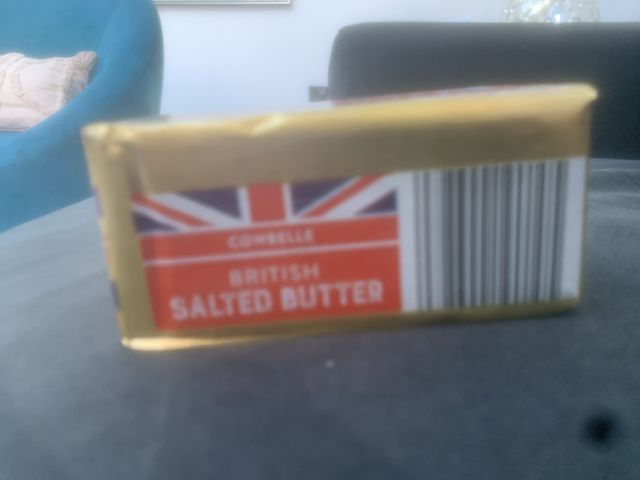

In [46]:
openai_text = "butter"

acs.sentence_transformers_query_search(openai_text,
                                       centers=clusterCenters,
                                       model=model,
                                       topn=1)

Finding 1 images with Open AI text query: APRICOTS 

{'Content': './images/catalog_images/catalog_image_00227.jpg', '@search.score': 186.9129, '@search.highlights': None}

1 Image file: ./images/catalog_images/catalog_image_00227.jpg
Similarity score = 186.9129


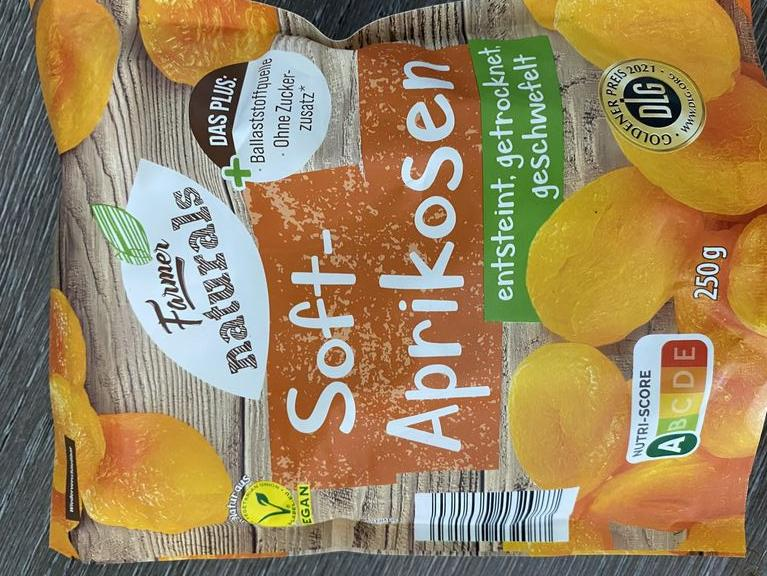

In [47]:
openai_text = "apricots"

acs.sentence_transformers_query_search(openai_text,
                                       centers=clusterCenters,
                                       model=model,
                                       topn=1)

Finding 1 images with Open AI text query: JAM 

{'Content': './images/catalog_images/catalog_image_00134.jpg', '@search.score': 190.50136, '@search.highlights': None}

1 Image file: ./images/catalog_images/catalog_image_00134.jpg
Similarity score = 190.50136


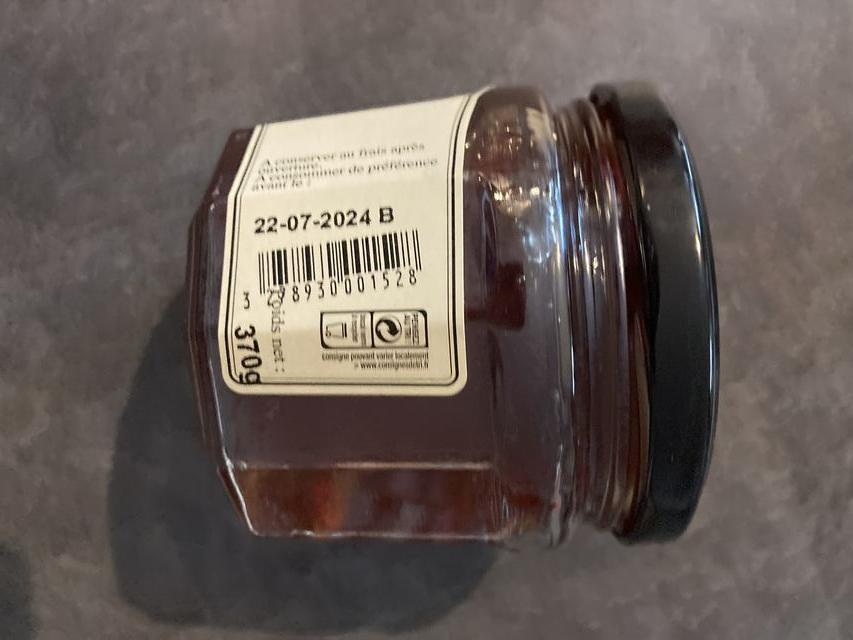

In [48]:
openai_text = "jam"

acs.sentence_transformers_query_search(openai_text,
                                       centers=clusterCenters,
                                       model=model,
                                       topn=1)

 ## 6. Searching images using extracted Text from Azure Read API

We can search on results from Azure Computer Vision & Azure Read API: OCR text, Barcode text, image tags, image main colors and image caption

In [49]:
text = "LAIT"

In [50]:
%%time
list_of_files = acs.open_text_query(text, False, 10)


Search using query = LAIT - note: displaying only the first 10 results 

 1 Image file: ./images/catalog_images/catalog_image_00083.jpg 

OCR:  LUNSUMMER DE PREFERENCE AVANT LE ( N- DE LOT : (V229 11.32.1º MONOPRIX LAIT Lait > collecté et conditionne France DEMI ÉCRÉMÉ CE LAIT RÉMUNÉRÉ AU JUSTE PRIK 14 STERILISE U.H.T. 
BarCode:   
Colors:  Grey 
Tags:  text packaging and labeling label box blue 
Caption:  a blue box with a label on it  

 2 Image file: ./images/catalog_images/catalog_image_00082.jpg 

OCR:  MONOPRIX LAIT Lait 9 conditionné France DEMI ÉCRÉMÉ CE LAIT RÉMUNÉRÉ AU JUSTE PRIX IL STÉRILISÉ U.H.T. 
BarCode:   
Colors:  Grey 
Tags:  text label packaging and labeling general supply material property blue floor 
Caption:  text  

 3 Image file: ./images/catalog_images/catalog_image_00057.jpg 

OCR:  yoplait® Crěme ENTIÈRE Lait 100% 3 329770 062740 Français 38 cl ℮ 
BarCode:  3329770062740 
Colors:  Grey White 
Tags:  text bottle plastic bottle food indoor 
Caption:  a bottle 

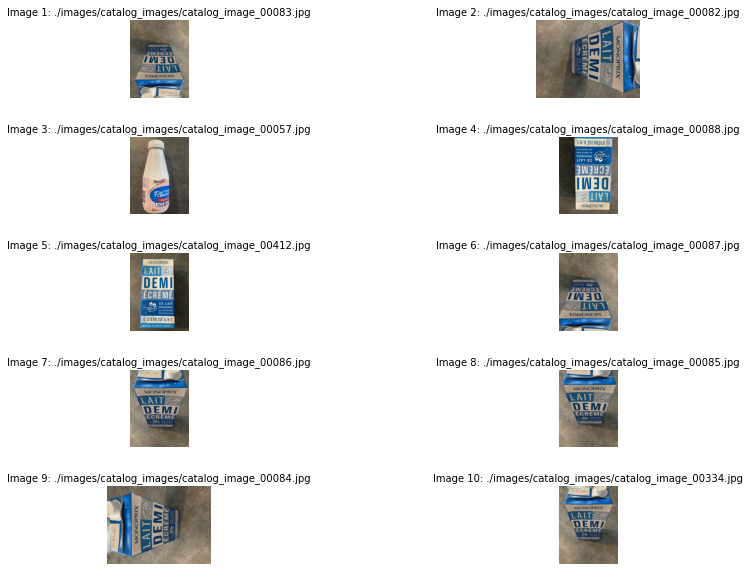

In [51]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [52]:
text = "sardine"

In [53]:
list_of_files = acs.open_text_query(text, False, 5)


Search using query = sardine - note: displaying only the first 5 results 

 1 Image file: ./images/catalog_images/catalog_image_00207.jpg 

OCR:  ALMARE 'Sardinen in Sonnen- SEAFOOD blumenöl, ohne Haut und ohne Gräten, mit Zitrone Zutaten: 75 %1 Sardinen, Sonnenblumenöl, Zitrone, Kochsalz. Gewichtsverlust durch Erhitzen. Nach dem Öffnen in einem nicht metallischen Behälter im Kühlschrank lagern und alsbald verzehren. Durchschnittliche Nährwerte Handelsbezeichnung: Sardine Je 100 g Gesamtprodukt Lat. Bezeichnung: Sardina pilchardus Brennwert 1352 KJ / 326 kcal Produktionsmethode: Wildfang (Meer) Fett Fangmethode: Umschließungsnetze 27 g - davon gesättigte und Hebenetze Fettsäuren 4,9 g Fanggerät: Ringwaden Fanggebiet: Mittlerer Ostatlantik (FAO 34) Kohlenhydrate <0,5 g Subfanggebiet: Nördliche Küstengewässer - davon Zucker <0,5 g Fangzeitraum: ganzjährig Eiweiß 20 g CROWN Salz 0,73 g o trennt man richtig- Durchschnittliche Nährwerte unterliegen Gelbe jahreszeitlich bedingten Schwankung

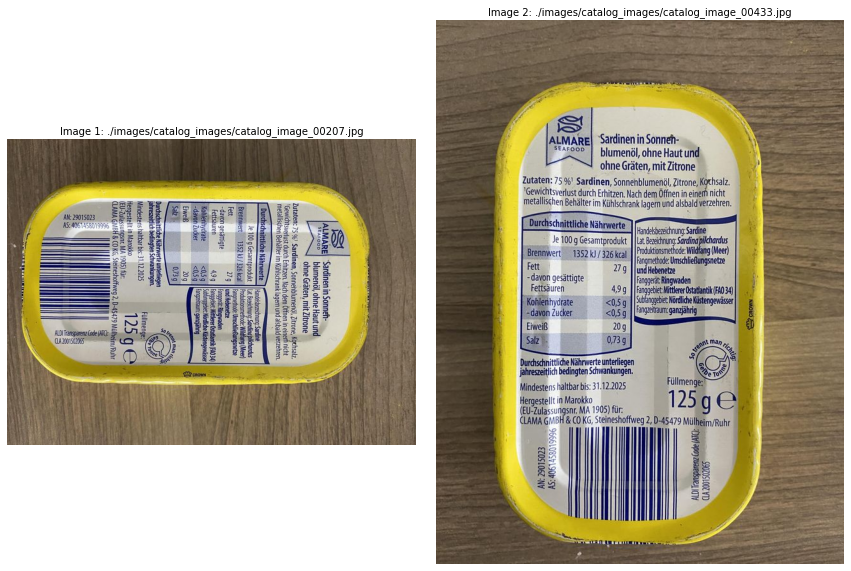

In [54]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [55]:
text = "4061458019996"

In [56]:
list_of_files = acs.open_text_query(text, False, 5)


Search using query = 4061458019996 - note: displaying only the first 5 results 

 1 Image file: ./images/catalog_images/catalog_image_00207.jpg 

OCR:  ALMARE 'Sardinen in Sonnen- SEAFOOD blumenöl, ohne Haut und ohne Gräten, mit Zitrone Zutaten: 75 %1 Sardinen, Sonnenblumenöl, Zitrone, Kochsalz. Gewichtsverlust durch Erhitzen. Nach dem Öffnen in einem nicht metallischen Behälter im Kühlschrank lagern und alsbald verzehren. Durchschnittliche Nährwerte Handelsbezeichnung: Sardine Je 100 g Gesamtprodukt Lat. Bezeichnung: Sardina pilchardus Brennwert 1352 KJ / 326 kcal Produktionsmethode: Wildfang (Meer) Fett Fangmethode: Umschließungsnetze 27 g - davon gesättigte und Hebenetze Fettsäuren 4,9 g Fanggerät: Ringwaden Fanggebiet: Mittlerer Ostatlantik (FAO 34) Kohlenhydrate <0,5 g Subfanggebiet: Nördliche Küstengewässer - davon Zucker <0,5 g Fangzeitraum: ganzjährig Eiweiß 20 g CROWN Salz 0,73 g o trennt man richtig- Durchschnittliche Nährwerte unterliegen Gelbe jahreszeitlich bedingten Schw

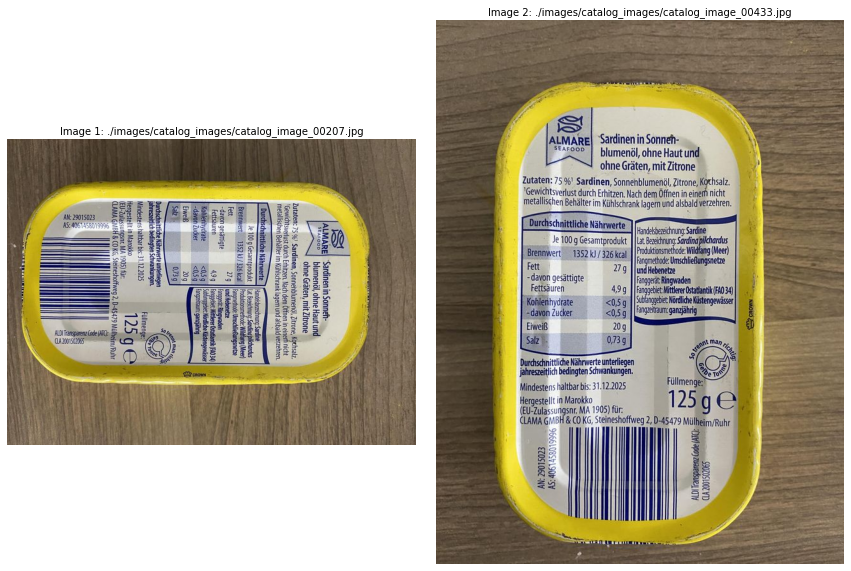

In [57]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [58]:
text = "red can"

In [59]:
list_of_files = acs.open_text_query(text, False, 10)


Search using query = red can - note: displaying only the first 10 results 

 1 Image file: ./images/catalog_images/catalog_image_00056.jpg 

OCR:  PROTEGE Tetra Pak® O BUENO TOMATE FRITO Una vez abierto conservar en frigorífico y consumir antes de 5 días. Consumir preferentemente antes del fin de/lote: ver parte superior. PESO NETO: 350g ℮ 
BarCode:   
Colors:  Red 
Tags:  text label logo material property brand red 
Caption:  a red can of soda  

 2 Image file: ./images/catalog_images/catalog_image_00385.jpg 

OCR:  CEPDEHACIÓN NUTRICIONAL CADRES MED OS LA 100 &. DE PRODUCTO (PNE) 851 2 kJ / 158,4 kcal BELAS CULES 16 ATOS DE CARBONO 2.20 FABRICADO FOR: < 0,05 g LA ESPAÑOLA' LA ESPAÑOLA ALIMENTARIA ALCOYANA S.A. ARZOBISPO DOMENECH 7 UZANILLA FINA 03804 ALCOY - ALICANTE - ESING WWW.LAESPANOLA.ES DER DEL SABOR HE ACIDO CITRICO REFERENCIA 150, ℮ 350, 370. CAPCOMSE LEEMMA 
BarCode:   
Colors:  Grey Red 
Tags:  text cylinder soft drink tin can tin bottle aluminum can red indoor container c

 25 Image file: ./images/catalog_images/catalog_image_00351.jpg 

OCR:   
BarCode:   
Colors:  Grey Orange 
Tags:  paper product stationary material property rectangle paper envelope red 
Caption:  a red and white box  

 26 Image file: ./images/catalog_images/catalog_image_00377.jpg 

OCR:  Orlando CALIDAD Y SABOR - DESDE 1922 - TOMATE FRITO El sofrito es la base de un buen tomate frito. Por eso en Orlando llevamos más de 50 años preparando nuestro sofrito como el que tú haces en casa. Descubre cómo lo hacemos en: Así es como conseguimos www.orlando.es el auténtico sabor a tomate frito Orlando. SERVICIO AL CONSUMIDOR 902 94 51 84 HJ Heinz Foods Spain SL. www.orlando.es Carretera Rincón de @Facebook Soto-Corella km 2,8 26540 Alfaro (La Rioja) 
BarCode:   
Colors:  White Red 
Tags:  text book material property publication font red 
Caption:  a red book on a table  

 27 Image file: ./images/catalog_images/catalog_image_00120.jpg 

OCR:  Géant Vert TM ugestion de puffsentation SANS CŒURS

 51 Image file: ./images/catalog_images/catalog_image_00270.jpg 

OCR:  SAXA SE SALT FINE 
BarCode:   
Colors:  Grey White 
Tags:  soft drink tin can bottle aluminum can wall indoor plastic 
Caption:  a blue bottle of shampoo  

 52 Image file: ./images/catalog_images/catalog_image_00022.jpg 

OCR:  MEREVALE MEDIUM 
BarCode:   
Colors:  Grey 
Tags:  text indoor label toothbrush 
Caption:  a red and white box  

 53 Image file: ./images/catalog_images/catalog_image_00300.jpg 

OCR:  MEREVALE MEDIUM 
BarCode:   
Colors:  Grey 
Tags:  text indoor label toothbrush 
Caption:  a red and white box  

 54 Image file: ./images/catalog_images/catalog_image_00275.jpg 

OCR:  SAXA SEA SALT FINE 
BarCode:   
Colors:  Grey White 
Tags:  text indoor tin can household supply tin wall 
Caption:  a blue and white can of soda  

 55 Image file: ./images/catalog_images/catalog_image_00379.jpg 

OCR:  LA 180250728 SEL Chaque grain SEL DE MER NATURELLEMENT de sel La Baleine BLANC est un bienfait de la mer, 

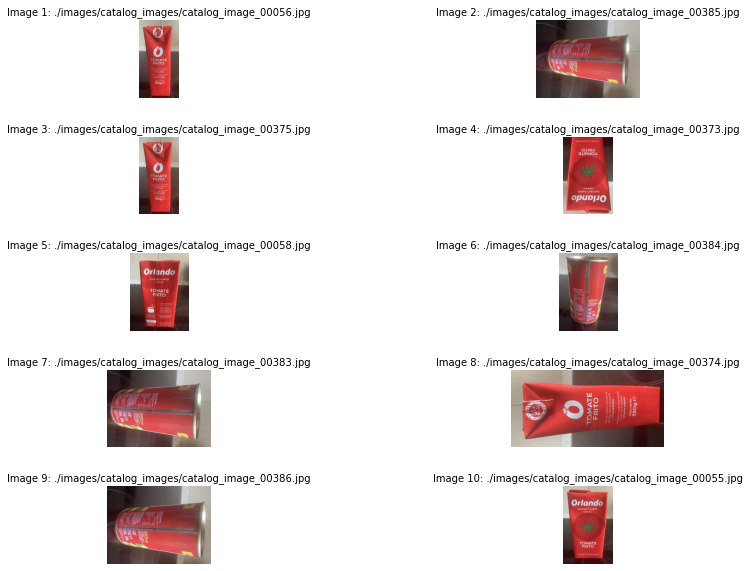

In [60]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [61]:
text = "www.orlando.es"

In [62]:
list_of_files = acs.open_text_query(text, False, 10)


Search using query = www.orlando.es - note: displaying only the first 10 results 

 1 Image file: ./images/catalog_images/catalog_image_00376.jpg 

OCR:  Orlando CALIDAD Y SABOR - DESDE 1922 - TOMATE FRITO El sofrito es la base de un buen tomate frito. Por eso en Orlando llevamos más de 50 años preparando nuestro sofrito como el que tú haces en casa. Descubre cómo lo hacemos en: Así es como conseguimos www.orlando.es el auténtico sabor a tomate frito Orlando. SERVICIO AL CONSUMIDOR HJ Heinz Foods Spain SL. C 90294 51 84 Carretera Rincón de www.orlando.es Soto-Corella km 2,8 Facebook 26540 Alfaro (La Rioja) 
BarCode:   
Colors:  Red 
Tags:  text material property label red 
Caption:  calendar  

 2 Image file: ./images/catalog_images/catalog_image_00058.jpg 

OCR:  Orlando CALIDAD Y SABOR - DESDE 1922 - TOMATE FRITO El sofrito es la base de un buen tomate frito. Por eso en Orlando llevamos más de 50 años preparando nuestro sofrito como el que tú haces en casa. Descubre cómo lo hacemos 

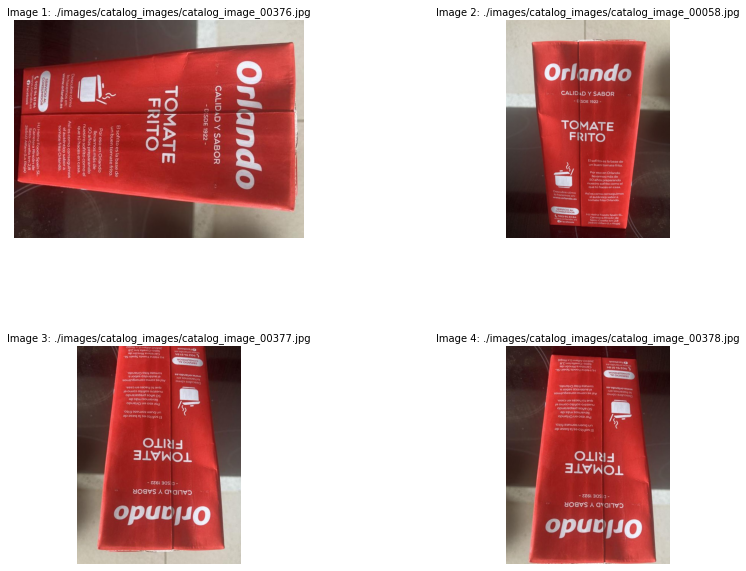

In [63]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

## 7. Global visual search using OpenAI Clip + Azure Read API + Azure Computer Vision + Barcode extraction)

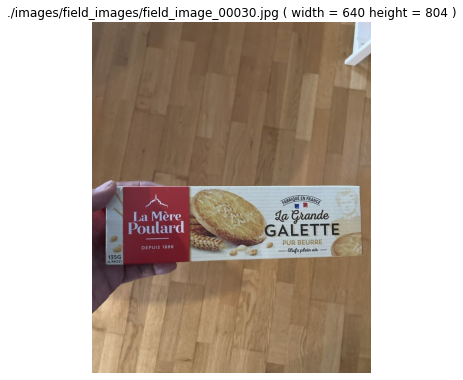

In [64]:
reference_image = FIELD_IMAGES + "field_image_00030.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [65]:
global_list, vectext_list, ocr_list, barcode_list = acs.global_search(
    reference_image, clusterCenters, model, topn=3)

[Step 1. Running images similarity visual search...]

Finding 3 similar images of reference image: ./images/field_images/field_image_00030.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00001.jpg Similarity score = 341.95056 
 2 Similar image: ./images/catalog_images/catalog_image_00076.jpg Similarity score = 274.3085 
 3 Similar image: ./images/catalog_images/catalog_image_00078.jpg Similarity score = 219.27121 

[Step 2. Extracting any text from the image...]

[Result] Text has been found:
OCR results from the image: FABRIQUÉ EN FRANCE La Mère Poulard La Grande GALETTE DEPUIS 1888 PUR BEURRE 135G - Œufs plein air - 4.76OZ


Search using query = FABRIQUÉ EN FRANCE La Mère Poulard La Grande GALETTE DEPUIS 1888 PUR BEURRE 135G - Œufs plein air - 4.76OZ - note: displaying only the first 3 results 

 1 Image file: ./images/catalog_images/catalog_image_00001.jpg 

OCR:  FABRIQUÉ EN FRANCE La Mère Poulard La Grande GALETTE DEPUIS 1888 PUR BEURRE 135G Œufs plein air - (4.7602)

OCR:  SAINT LOUIS --- 1565 LES ATOUTS DU « PACK» PROTEGE DE PACK RIGIDE BOUCHON L'HUMIDITÉ PRÉCISION Sucre roux de canne Brown cane sugar Pour / Per 100 g Energie / Energy 1683 kJ / 396 kcal Matières grasses / Fat 0 g dont acides gras saturés / of which saturates Glucides / Carbohydrate 99 g dont sucres / of which sugars 99 g Protéines / Protein 0 g Sel / Salt 0 g Saint Louis Sucre · Parc du Millénaire 2 35, rue de la Gare - 75019 Paris - France SERVICE CONSOMMATEURS Écrire à l'adresse ci-dessus en indiquant : «Service Consommateurs» www.saintlouis-sucre.com 3 220035 229000 650 g 
BarCode:  3220035229000 
Colors:  Grey Black White 
Tags:  text paper food 
Caption:  text, letter  

 17 Image file: ./images/catalog_images/catalog_image_00423.jpg 

OCR:  "Ce lait français rémunère au juste prix son productour LAIT STÉRILISÉ U.H.T. DEMI-ÉCRÉMÉ INGRÉDIENT : Zait demi-écrémé. Les informations en gras sont destinées aux personnes intolerantes ou allergiques. Ce lait répond à un cahier des cha

 51 Image file: ./images/catalog_images/catalog_image_00088.jpg 

OCR:  MONOPRIX LAIT Lait ! France DEMI ECREME CE LAIT C'est qui le RÉMUNÈRE patron ?! AU JUSTE PRIX SON PRODUCTEUR IL STÉRILISÉ U.H.T. 
BarCode:   
Colors:  Blue Grey White 
Tags:  text font book poster publication sign 
Caption:  text  

 52 Image file: ./images/catalog_images/catalog_image_00105.jpg 

OCR:  H 16 1 Auchan IN Pour un réveil tropical 100% PUR JUS Ananas Suggestion de présentation NUTRI-SCORE ABCDE Jus d'ananas, 1L flash pasteurise 
BarCode:   
Colors:  Grey Yellow 
Tags:  text food snack fast food chip 
Caption:  text, calendar  

 53 Image file: ./images/catalog_images/catalog_image_00393.jpg 

OCR:  o Calvo Distribución f Calvo Servicio de atención VUELCA Con tecnología PEEL Alimentaria, S.L.U. visitanos en al consumidor. FACIL Desprende Vuelca y extrae Misma cantidad Ctra. A Coruña-Finisterre Km. 34,5 15106 Carballo A Coruña, España calvo.esp 900 825 800 una idea de la tapa todo el de atun y Calvo fáci

 101 Image file: ./images/catalog_images/catalog_image_00387.jpg 

OCR:  NUEVO ENVASE Calvo® VUELCA Atún claro Una lata FÁCIL® en aceite de atún claro de oliva. de regalo una idea de Calvo 
BarCode:   
Colors:  White Yellow Grey 
Tags:  text food 
Caption:  a close-up of some food  

 102 Image file: ./images/catalog_images/catalog_image_00147.jpg 

OCR:  PALAIS DES THES holivon épicurienne aux immenses mas le monde pour sélectionner www que nous cultivons avec nos producteurs Fabio des Thes signe, à Paris, des thes et infusion ein Adorde les signe, a Paris, des thes et infundir. is full of flavour and a delightfully Bacio partesuastatt experience, we travel the world to bring Haver wird es museumiming strong partnerships with our grower Ccare er muchun Fabris des Thes designs in Paris delicious and a Louvre / Côté Jardin · Garden tea and de nos Tea Sommeliers / Tips from our Tea Sommeliers a swi glacé /also delicious iced: infusez 8g dans 50cl d'eau à eliane ih Retirez les feuilles de

[Result] No barcode/QRCode has been found

Done in 6.68026 sec


In [66]:
df = pd.DataFrame()
df['image'] = global_list
df

image
0  ./images/catalog_images/catalog_image_00001.jpg
1  ./images/catalog_images/catalog_image_00076.jpg
2  ./images/catalog_images/catalog_image_00078.jpg
3  ./images/catalog_images/catalog_image_00077.jpg

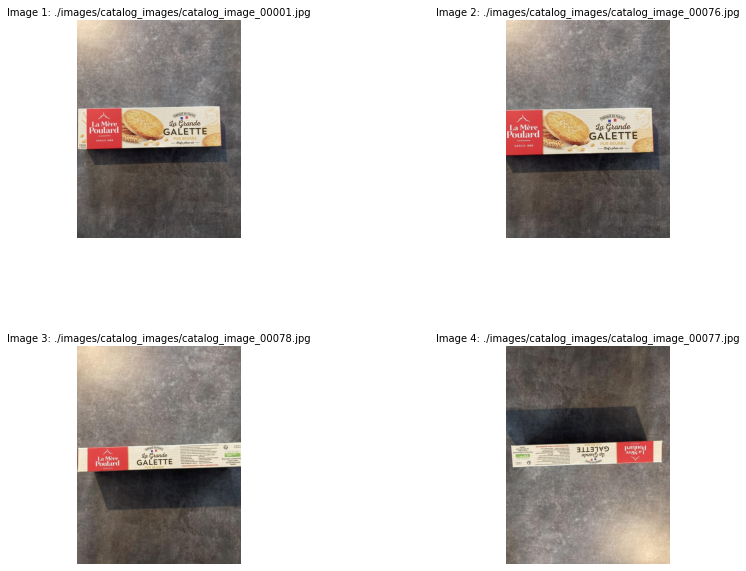

In [67]:
my.display_multiple_images(global_list, nb_cols=2, hspace=0.5, wspace=0.05, axis=False)

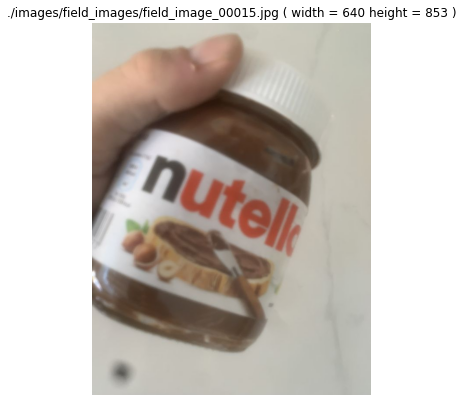

In [68]:
reference_image = FIELD_IMAGES + "field_image_00015.jpg"

my.image_view(reference_image, h=8, w=5, axis=False)

In [69]:
global_list, vectext_list, ocr_list, barcode_list = acs.global_search(
    reference_image, clusterCenters, model, topn=3)

[Step 1. Running images similarity visual search...]

Finding 3 similar images of reference image: ./images/field_images/field_image_00015.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00463.jpg Similarity score = 304.16446 
 2 Similar image: ./images/catalog_images/catalog_image_00259.jpg Similarity score = 278.12692 
 3 Similar image: ./images/catalog_images/catalog_image_00260.jpg Similarity score = 268.7456 

[Step 2. Extracting any text from the image...]

[Result] Text has been found:
OCR results from the image: nutell


Search using query = nutell - note: displaying only the first 3 results 


[Step 3. Extracting any text any barcode/QRCode of the image...]

[Result] No barcode/QRCode has been found

Done in 5.68853 sec


In [70]:
df = pd.DataFrame()
df['image'] = global_list
df

image
0  ./images/catalog_images/catalog_image_00463.jpg
1  ./images/catalog_images/catalog_image_00259.jpg
2  ./images/catalog_images/catalog_image_00260.jpg

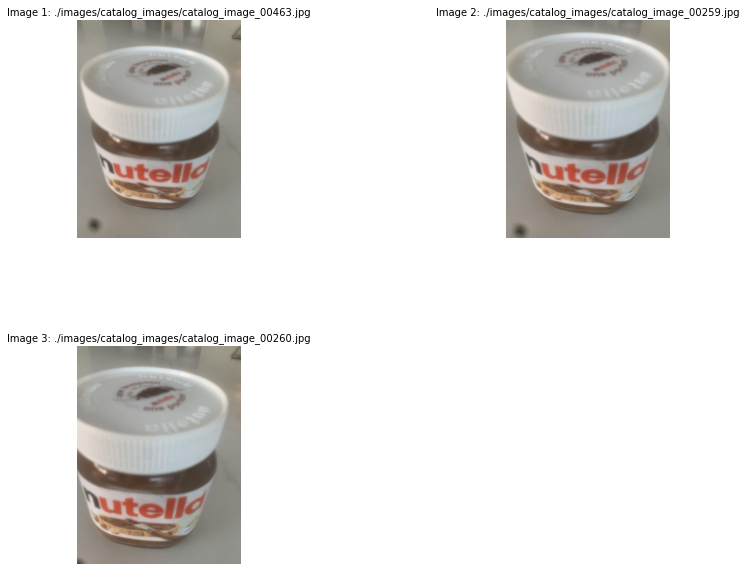

In [71]:
my.display_multiple_images(global_list, nb_cols=2, hspace=0.5, wspace=0.05, axis=False)

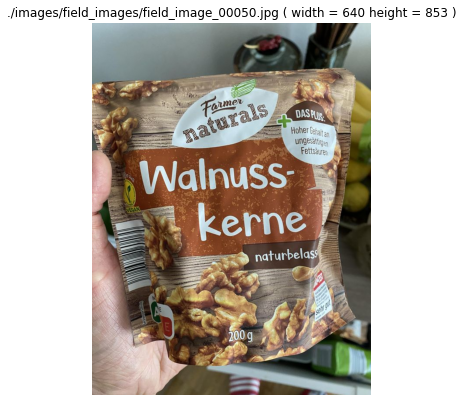

In [72]:
reference_image = FIELD_IMAGES + "field_image_00050.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [73]:
global_list, vectext_list, ocr_list, barcode_list = acs.global_search(
    reference_image, clusterCenters, model, topn=3)

[Step 1. Running images similarity visual search...]

Finding 3 similar images of reference image: ./images/field_images/field_image_00050.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00072.jpg Similarity score = 401.7869 
 2 Similar image: ./images/catalog_images/catalog_image_00071.jpg Similarity score = 240.11288 
 3 Similar image: ./images/catalog_images/catalog_image_00403.jpg Similarity score = 233.19392 

[Step 2. Extracting any text from the image...]

[Result] Text has been found:
OCR results from the image: Farmer DAS PLUS naturals Hoher Gehalt an ungesättigten Walnuss- Fettsäuren VEGAN kerne naturbelass NE sehr gut E 200 g


Search using query = Farmer DAS PLUS naturals Hoher Gehalt an ungesättigten Walnuss- Fettsäuren VEGAN kerne naturbelass NE sehr gut E 200 g - note: displaying only the first 3 results 

 1 Image file: ./images/catalog_images/catalog_image_00072.jpg 

OCR:  Farmer DAS PLUS .. naturals Hoher Gehalt an ungesättigten Walnuss- Fettsäuren EGAN

 51 Image file: ./images/catalog_images/catalog_image_00248.jpg 

OCR:  Farmer naturals Soft- Durchschnittliche Nährwerte 100g Datteln Brennwert 1145 KJ /277 kcal - davon gesättigte <0,5 g Fettslune entsteint getrocknet Kohlenhydrate -davon Zucker 52 % Ballaststoffe 11g 249 Soft-Datteln, getrocknet, eatsteint. Exsfertig Zutaten: Getrocknete Datteln, Wasser. Die Farmer Naturals Soft-Dutrein eignen och ideal als Zutat am Masll oder Joghurt. Aber soch zum Kochen oder als kleiner Snack Zwischendurch sind die Datteln bestens Nach dem Öffnen im Kühlschrank aufbewah geelgort. res und innerhalb von 10 Tagen verbrauchen Wamhinweis: Trotz mehrfacher Kontrolle then sich auch bei sorgfältiger Verpackung Pendkorper (z.B. Stängel, Steine oder gewreste) nicht ganz vermeiden. Mindestens haltbar bis: AS: 4061462132700 lestellt für: Woord Janssen GmbH sdethestr. 180 Wie, Deutschland 250 g ℮ 31.03.2023 L : 350020356/2-11-248 
BarCode:   
Colors:  Grey White 
Tags:  text sausage food 
Caption:  text, lett

 101 Image file: ./images/catalog_images/catalog_image_00240.jpg 

OCR:  ·Sesampaste. Zutaten: geröstete, gemahlene Sesamsamen. Gebrauch gut schütteln. Mindestens haltbar bis: siehe Deckel. 4. Tahin. İçindekiler: kavrulmuş, öğütülmüş susam. İşletmadan önce çalkalayınız. Son kullanma tarihi: kapakdaki tascaya bakınız. Veame paste. Ingredients: roasted, milled sesame seeds hopewell before use. Best before: see lid. w rasta sezamowa. Składniki: prażone, zmielone nasiona Pertu Przed spożyciem dobrze wstrząsnąć. Najlepiej spożyć Kald nadruk, podany na wieczku." *% wampasta. Ingredienser: ristede, malede sesamfra mesiden brun. Bedst før. se print øverst. Wwwively manufactured for: 20040pt. Germany 100 %. Kluge Gmbh & Co. KG - Industriestraße 40-42 300 g / 291 ml ny . www.kreyenhop.com 
BarCode:   
Colors:  Grey Yellow 
Tags:  bottle text food storage containers lid preserved food condiment food indoor yellow 
Caption:  a jar of peanut butter  

 102 Image file: ./images/catalog_images/catalo

 151 Image file: ./images/catalog_images/catalog_image_00224.jpg 

OCR:  Mars nutritionnelles pour 100g : forte: 252 kcal/ 1057kJ - Graisses: NORMANDIE Saveurs de NSg (dont acides gras saturés : 0g) André Guéprate lucides : 62g (dont sucres : 62g) - Puréines : 04g- Sek: < 0,01g rédients : fruits, sucre, pectine de Gelée de somno de Normandie Miparé aves 55 g de fruits pour Virey - 50600 Saint Tel. 02 33 49 21 95 
BarCode:   
Colors:  Grey Black 
Tags:  text fruit preserve preserved food food storage containers lid food condiment canning mason jar lekvar bottle jam indoor 
Caption:  a jar of food  

 152 Image file: ./images/catalog_images/catalog_image_00385.jpg 

OCR:  CEPDEHACIÓN NUTRICIONAL CADRES MED OS LA 100 &. DE PRODUCTO (PNE) 851 2 kJ / 158,4 kcal BELAS CULES 16 ATOS DE CARBONO 2.20 FABRICADO FOR: < 0,05 g LA ESPAÑOLA' LA ESPAÑOLA ALIMENTARIA ALCOYANA S.A. ARZOBISPO DOMENECH 7 UZANILLA FINA 03804 ALCOY - ALICANTE - ESING WWW.LAESPANOLA.ES DER DEL SABOR HE ACIDO CITRICO REFEREN

[Result] Barcode/QRCode text has been found:
Barcode results from the image: 4061461689087


Search using query = 4061461689087 - note: displaying only the first 3 results 

 1 Image file: ./images/catalog_images/catalog_image_00402.jpg 

OCR:  naturals Walnuss- Durchschnittliche Nährwerte kerne Brenfrevert 1954 6/ 716 kcal Fett - davon gesättigte Fettsaune - davon einfach ungesange lesascen naturbelassen -davon mehrfach ungesinige femsauren 529 Kohlenhydrate - davon Zucker 32g DAS PLUS: 17 Der Ersatz gesättigter Fettsäuren durch einfach Salz und/oder mehrfach ungesättigte Fettsäuren in der Emährung trägt zur Aufrechterhaltung eines normalen Cholesterinspiegels im Blut bei .* T. Walnüsse tragen dazu bei, die Elastizität der Blutgefäße zu verbessern .* Kalifornische Walnussterne Zutaten: Walnusskerne. Kann Spuren von anderen Schalenfrüchten vod Erdnissen enthalten. ERje positive wirkung stelt sich bei einem täglichen Verzehr hg talerkenen tin. Eine abwechslungsreiche, ausgewogene dames 

In [74]:
df = pd.DataFrame()
df['image'] = global_list
df

image
0  ./images/catalog_images/catalog_image_00072.jpg
1  ./images/catalog_images/catalog_image_00071.jpg
2  ./images/catalog_images/catalog_image_00403.jpg
3  ./images/catalog_images/catalog_image_00458.jpg
4  ./images/catalog_images/catalog_image_00242.jpg
5  ./images/catalog_images/catalog_image_00402.jpg
6  ./images/catalog_images/catalog_image_00400.jpg

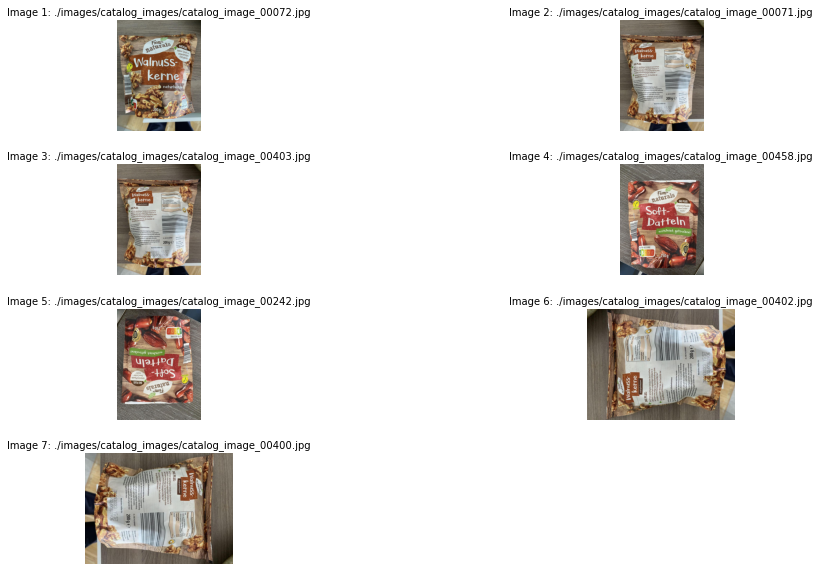

In [75]:
my.display_multiple_images(global_list, nb_cols=2, hspace=0.3, wspace=0.5, axis=False)

> End of notebook